In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import onnxruntime as ort
import utils
from util_onnx import onnx_export
import utils
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6,7"
import gc
gc.collect()

0

---
##### Load the ONNX model


In [2]:
save_path = '../onnx_models_cuda'

In [3]:
def load_session(path, provider = 'cuda'):
    if provider == 'cuda':
        return ort.InferenceSession(path, providers=['AzureExecutionProvider'])
    else:
        return ort.InferenceSession(path)

- Text Encoder

In [4]:
sessTokenizer       = load_session(f'{save_path}/tokenizer/to_quant.onnx')
sessionTextEncoder  = load_session(f'{save_path}/text_encoder/te_quant.onnx')

- Denoising

In [5]:
sessUNetPre     = load_session(f'{save_path}/unet/upre_quant.onnx')
sessUNetDown    = load_session(f'{save_path}/unet/udown_quant.onnx')
sessUNetMid     = load_session(f'{save_path}/unet/umid_quant.onnx')
sessUNetUp00    = load_session(f'{save_path}/unet/uup-0_quant.onnx')
sessUNetUp10    = load_session(f'{save_path}/unet/uup-1_quant.onnx')
sessUNetUp20    = load_session(f'{save_path}/unet/uup-2_quant.onnx')
sessUNetUp30    = load_session(f'{save_path}/unet/uup-3-0_quant.onnx')
sessUNetUp31    = load_session(f'{save_path}/unet/uup-3-1_quant.onnx')
sessUNetUp32    = load_session(f'{save_path}/unet/uup-3-2_quant.onnx')
sessUNetPost    = load_session(f'{save_path}/unet/upost_quant.onnx')

- Schedulers

In [6]:
sessScheduler981     = load_session(f'{save_path}/scheduler/sche981_quant.onnx')
sessScheduler9611    = load_session(f'{save_path}/scheduler/sche9611_quant.onnx')
sessScheduler9612    = load_session(f'{save_path}/scheduler/sche9612_quant.onnx')
sessScheduler941     = load_session(f'{save_path}/scheduler/sche941_quant.onnx')
sessSchedulerNN      = load_session(f'{save_path}/scheduler/scheNN_quant.onnx')

- Decoder

In [7]:
sessDecoder      = load_session(f'{save_path}/decoder/de_quant.onnx')

In [8]:
schedulers = {
    i:ort.InferenceSession(f'../onnx-models/Schedulers_quant/{i}') for i in os.listdir(f'../onnx-models/Schedulers_quant/')
}

---
Main

In [9]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(device = 0)) # 'NVIDIA TITAN X (Pascal)'

# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count()) # 3

True
NVIDIA A100-SXM4-40GB
2


In [10]:
device = "cpu"
dtype = torch.float32
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cpu
Current cuda device: 0
Count of using GPUs: 2


- Text Input 👉 Text Embedding

In [11]:
ascii_str   = utils.toAsciiTensor()
text_ids = sessTokenizer.run(None, {
    'input' : ascii_str.detach().cpu().numpy()
})[0]
print(text_ids.shape)
print(text_ids)

(1, 77)
[[49407   320  3490  2368 49406     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]


In [12]:
embed = sessionTextEncoder.run(None, {
    'input' : text_ids
})[0]

In [16]:
import os
import torch
import torch.nn as nn
from diffusers.schedulers import PNDMScheduler
from pathlib import Path
from diffusers import DiffusionPipeline
device = 'cpu'
dtype = torch.float32
save_path = '../onnx_models_cuda'
os.makedirs(save_path, exist_ok = True)

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32).to(device)

Couldn't connect to the Hub: 401 Client Error. (Request ID: Root=1-66e489cf-76a2198e122e74a44682be42;032323c1-948c-4e48-9070-12812efae5ef)

Repository Not Found for url: https://huggingface.co/api/models/runwayml/stable-diffusion-v1-5.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password..
Will try to load from local cache.


In [14]:
latents0 = torch.randn([1,4,64,64], dtype= dtype, device =device)

In [18]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = latents0.clone()
extra_step_kwargs = {}
for i, t in enumerate(timesteps):
    latent_model_input = torch.cat([latents] * 2).to(device = device)
    latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    # predict the noise residual
    noise_pred = pipeline.unet(
        latent_model_input.to(device = device),
        t,
        encoder_hidden_states=torch.tensor(embed).to(device = device),
        cross_attention_kwargs=None,
        return_dict=False,
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

981 -> 
961 -> 961 -> 941 -> 921 -> 901 -> 881 -> 861 -> 841 -> 821 -> 801 -> 
781 -> 761 -> 741 -> 721 -> 701 -> 681 -> 661 -> 641 -> 621 -> 601 -> 
581 -> 561 -> 541 -> 521 -> 501 -> 481 -> 461 -> 441 -> 421 -> 401 -> 
381 -> 361 -> 341 -> 321 -> 301 -> 281 -> 261 -> 241 -> 221 -> 201 -> 
181 -> 161 -> 141 -> 121 -> 101 -> 81 -> 61 -> 41 -> 21 -> 1 -> 


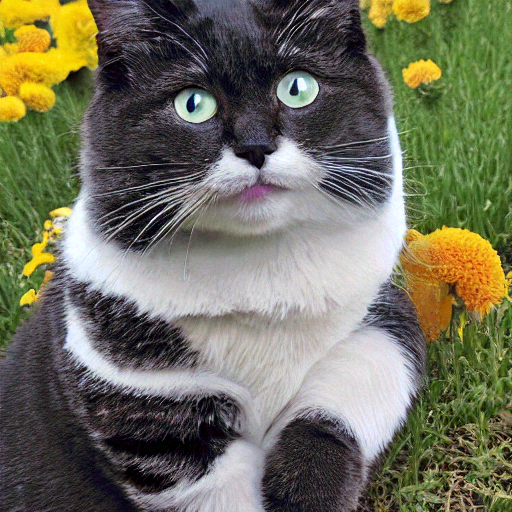

In [19]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

output = sessDecoder.run(None, {
    'input': latents.detach().numpy()
})[0]
img = numpy_to_pil(output[0])
img[0].show()

---

In [29]:
sessUpList  = [sessUNetUp00, sessUNetUp10, sessUNetUp20]
up_3_list   = [sessUNetUp30, sessUNetUp31, sessUNetUp32]

def forward_UNet(
    x,          # x : [1 4 64 64]
    t,          # t : [1]
    text_embed  # text_embed : [2 77 768]
):
    #* Pre
    output = sessUNetPre.run(None, {
        sessUNetPre.get_inputs()[0].name: x,
    })[0]
    #* Down
    outputs = sessUNetDown.run(None, {
        sessUNetDown.get_inputs()[0].name: output,
        sessUNetDown.get_inputs()[1].name: t,
        sessUNetDown.get_inputs()[2].name: text_embed
    })
    sample, emb, down_block_res_samples = outputs[0], outputs[1], outputs[2:]
    #* Mid
    outputs = sessUNetMid.run(None, {
        sessUNetMid.get_inputs()[0].name: sample,
        sessUNetMid.get_inputs()[1].name: emb,
        sessUNetMid.get_inputs()[2].name: text_embed
    })
    sample = outputs[0]
    #* Up
    for i in range(3):
        res_samples = down_block_res_samples[-3 :]
        down_block_res_samples = down_block_res_samples[: -3]
        if i == 0:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: res_samples[0],
                sessUpList[i].get_inputs()[3].name: res_samples[1],
                sessUpList[i].get_inputs()[4].name: res_samples[2],
            })
            sample = outputs[0]
            # print(sample.shape)
        else:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: text_embed,
                sessUpList[i].get_inputs()[3].name: res_samples[0],
                sessUpList[i].get_inputs()[4].name: res_samples[1],
                sessUpList[i].get_inputs()[5].name: res_samples[2],
            })
            sample = outputs[0]          
    for i in range(3):
        outputs = up_3_list[i].run(None, {
            up_3_list[i].get_inputs()[0].name: sample,
            up_3_list[i].get_inputs()[1].name: emb,
            up_3_list[i].get_inputs()[2].name: text_embed,
            up_3_list[i].get_inputs()[3].name: down_block_res_samples[-(i+1)],
        })
        sample = outputs[0]
    outputs = sessUNetPost.run(
    None,{
        sessUNetPost.get_inputs()[0].name: sample,
    })
    sample = outputs[0]
    return sample, x

In [32]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = torch.randn([1,4,64,64], dtype= dtype, device =device)
extra_step_kwargs = {}
for i, t in enumerate(timesteps):
    noise_pred = forward_UNet(
        x = latents.detach().numpy(), 
        t = torch.tensor([t], dtype = dtype, device = device).detach().numpy(), 
        text_embed = embed
    )[0]
    # latent_model_input = torch.cat([latents] * 2).to(device = device)
    # latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    # # predict the noise residual
    # noise_pred = pipeline.unet(
    #     latent_model_input.to(device = device),
    #     t,
    #     encoder_hidden_states=torch.tensor(embed).to(device = device),
    #     cross_attention_kwargs=None,
    #     return_dict=False,
    # )[0]
    # noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    noise_pred = torch.tensor(noise_pred)
    latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

981 -> 
961 -> 961 -> 941 -> 921 -> 901 -> 881 -> 861 -> 841 -> 821 -> 801 -> 
781 -> 761 -> 741 -> 721 -> 701 -> 681 -> 661 -> 641 -> 621 -> 601 -> 
581 -> 561 -> 541 -> 521 -> 501 -> 481 -> 461 -> 441 -> 421 -> 401 -> 
381 -> 361 -> 341 -> 321 -> 301 -> 281 -> 261 -> 241 -> 221 -> 201 -> 
181 -> 161 -> 141 -> 121 -> 101 -> 81 -> 61 -> 41 -> 21 -> 1 -> 


In [33]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

In [36]:
output = sessDecoder.run(None, {
    'input': latents.detach().numpy()
})[0]

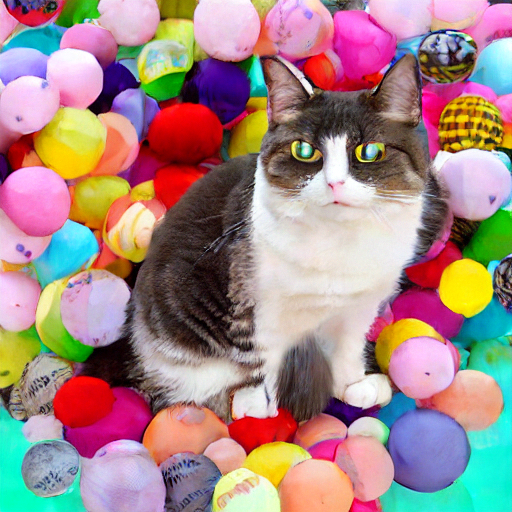

In [38]:
img = numpy_to_pil(output[0])
img[0].show()

In [78]:
latents00 = torch.randn([1,4,64,64], dtype= dtype, device =device).detach().numpy()

In [79]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
latents = latents00.copy()
extra_step_kwargs = {}
for idx, t in enumerate(timesteps):
    noise_pred = forward_UNet(
        x = latents, 
        t = torch.tensor([t], dtype = dtype, device = device).detach().numpy(), 
        text_embed = embed
    )[0]
    if t == 981:
        ets0 = noise_pred
        ort_outputs = schedulers['step-981.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,  
        })[0]
        cur_sample = ort_outputs
        latents = ort_outputs
    elif t == 961 and idx == 1:
        latents = schedulers['step-961_1.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : cur_sample,
            'ets'           : ets0
        })[0]
    elif t == 961 and idx == 2:
        latents = schedulers['step-961_2.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : latents,
            'ets'           : ets0
        })[0]
        ets1 = noise_pred
    elif t == 941:
        latents = schedulers['step-941.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : latents,
            'ets1'          : ets0,
            'ets2'          : ets1
        })[0]
        ets2 = noise_pred
    else:
        latents = schedulers[f'step-{t}.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,
            'ets1'          : ets0,        
            'ets2'          : ets1,
            'ets3'          : ets2
        })[0]
        ets0 = ets1
        ets1 = ets2
        ets2 = noise_pred
    # noise_pred = torch.tensor(noise_pred)
    # latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    # latents = latents.detach().numpy()
    print(t, end=' -> ' if (idx%10 != 0 and idx!= 0) else ' -> \n')

981 -> 
961 -> 961 -> 941 -> 921 -> 901 -> 881 -> 861 -> 841 -> 821 -> 801 -> 
781 -> 761 -> 741 -> 721 -> 701 -> 681 -> 661 -> 641 -> 621 -> 601 -> 
581 -> 561 -> 541 -> 521 -> 501 -> 481 -> 461 -> 441 -> 421 -> 401 -> 
381 -> 361 -> 341 -> 321 -> 301 -> 281 -> 261 -> 241 -> 221 -> 201 -> 
181 -> 161 -> 141 -> 121 -> 101 -> 81 -> 61 -> 41 -> 21 -> 1 -> 


In [60]:
[o.name for o in sessSchedulerNN.get_inputs()]

['noise_pred', 'timestep', 'latents', 'ets1', 'ets2', 'ets3']

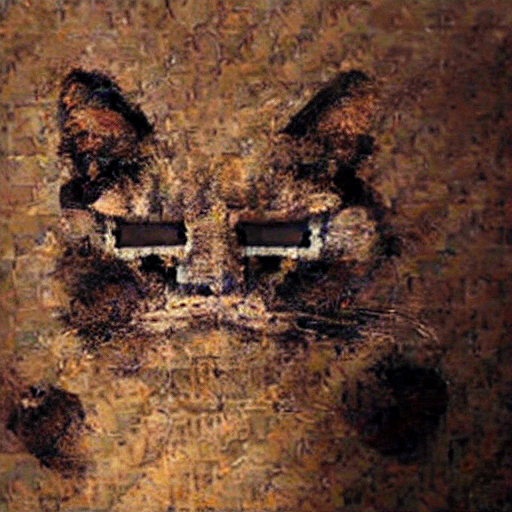

In [80]:
output = sessDecoder.run(None, {
    'input': latents
})[0]
img = numpy_to_pil(output[0])
img[0].show()

In [46]:
for idx, t in enumerate(timesteps):
    timestep = torch.tensor([t], dtype = dtype, device = device).detach().numpy()
    # (1) UNet
    noise_pred = forward_UNet(
        x = latents, 
        t = torch.tensor([t], dtype = dtype, device = device).detach().numpy(), 
        text_embed = embed)[0]
    
    # (2) Scheduler.step
    if t == 981:
        ets0 = noise_pred
        ort_outputs = sessScheduler981.run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,  
        })#[0]
        cur_sample = ort_outputs[1]
        latents = ort_outputs[0]
        
    elif t == 961 and idx == 1:
        latents = sessScheduler9611.run(None, {
            'noise_pred'    : noise_pred,
            'cur_sample'    : cur_sample,
            'ets'           : ets0
        })[0]
    elif t == 961 and idx == 2:
        latents = sessScheduler9612.run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : latents,
            'ets'           : ets0
        })[0]
        ets1 = noise_pred
    elif t == 941:
        latents = sessScheduler941.run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,
            'ets1'          : ets0,
            'ets2'          : ets1
        })[0]
        ets2 = noise_pred
    else:
        latents = sessSchedulerNN.run(None, {
            'noise_pred'    : noise_pred,
            'timestep'      : torch.tensor([t], dtype = torch.int64, device = device).detach().numpy(),
            'latents'       : latents,
            'ets1'          : ets0,        
            'ets2'          : ets1,
            'ets3'          : ets2
        })[0]
        ets0 = ets1
        ets1 = ets2
        ets2 = noise_pred
    
    print(t, end=' ➭ ' if (idx%10 != 0 and idx!= 0) else ' ➭ \n')

RuntimeError: Input must be a list of dictionaries or a single numpy array for input 'input'.

---
### Decoder

In [37]:
output[0].shape

(512, 512, 3)